# Package imports

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
import cv2

from traffic.paths import ROOT
from traffic.utils.colors import Vivid
from traffic.utils import image_utils
from traffic.tracker.track_info import TrackStatus

# Options

In [2]:
history_dir_path = ROOT / "data/runs/_example"

# Define a color map for regions
region_color_map = {
    "INCOMING": Vivid.BLUE,
    "OUTGOING": Vivid.RED,
}

# Load data

In [3]:
# Read parquet to pandas dataframe
df = pd.read_parquet(history_dir_path / "tracks.parquet")

# Postprocess data

In [4]:
# Add centroid coordinates from box coordinates
df["centroid_x"] = (df["box_left"] + df["box_right"])/2
df["centroid_y"] = (df["box_top"] + df["box_bottom"])/2

# Get the list of regions present in any of the tracks.
regions = df.region.unique().dropna().tolist()

# Get series mapping from track ID to region, based on the last non-null region encountered for each track.
region_series = df.dropna(subset="region")[["id", "region"]].groupby("id").last().region

# Analyze data

## Track centroid paths

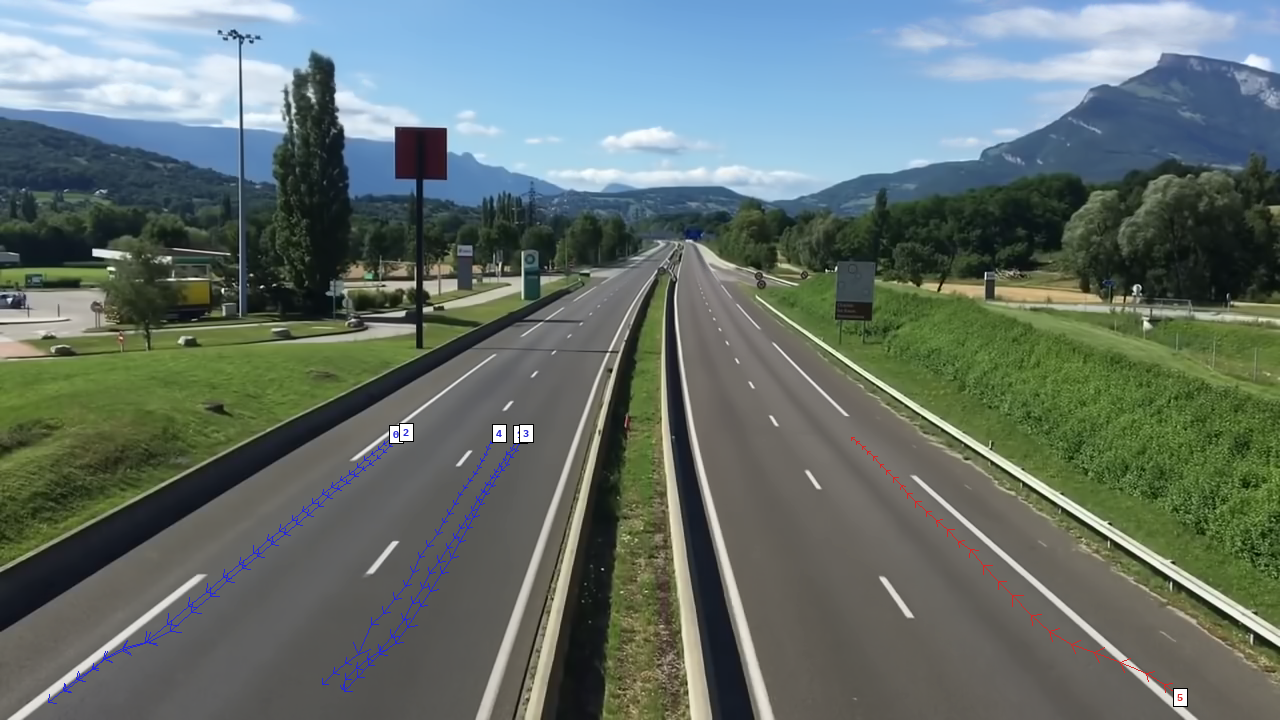

In [5]:
# Open background image as cv2 frame
frame = cv2.cvtColor(np.array(PIL.Image.open(str(ROOT / "data/background/background.png"))), cv2.COLOR_RGB2BGR)

def get_color(track_id):
    return region_color_map[region_series.loc[track_id]]

def get_centroid_path_points(track_id):
    return df[df.id == track_id][["centroid_x", "centroid_y"]].astype(int).to_numpy()

# Get list of all track IDs
track_ids = df.id.dropna().unique()

# Draw paths with arrowheads
for track_id in track_ids:
    centroid_path_points = get_centroid_path_points(track_id)
    for i in range(len(centroid_path_points) - 1):
        start_point = tuple(centroid_path_points[i])
        end_point = tuple(centroid_path_points[i + 1])
        cv2.arrowedLine(
            frame,
            start_point,
            end_point,
            color=get_color(track_id).bgr,
            thickness=1,
            tipLength=0.4,
        )

# Convert the image to PIL
image = PIL.Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Draw bubbles for track ID labels
draw = PIL.ImageDraw.Draw(image)
font_size = 10
font = PIL.ImageFont.truetype(image_utils.get_font_path("Bold"), font_size)
def add_bubble(track_id):
    centroid_path_points = get_centroid_path_points(track_id)
    point = tuple(centroid_path_points[0])
    x, y = point

    color = get_color(track_id).hex
    
    # Create the text to be displayed in the bubble
    text = str(track_id)
    text_width = draw.textlength(text, font)
    text_height = font_size
    
    # Define the bubble dimensions and padding
    padding = 4
    bubble_width = text_width + 2 * padding
    bubble_height = text_height + 2 * padding
    
    # Draw the bubble rectangle
    draw.rectangle(
        [(x - bubble_width // 2, y - bubble_height // 2), (x + bubble_width // 2, y + bubble_height // 2)],
        fill="white",
        outline="black",
    )
    
    # Draw the text inside the bubble
    draw.text(
        (x - text_width // 2, y - text_height // 2 - padding // 2),
        text,
        fill=color,
        font=font
    )
    
    return image


# Add text bubbles to the image
for track_id in track_ids:
    add_bubble(track_id)

image

## Number of tracks in each region

Based on the last non-null region encountered for each track.


In [6]:
df.dropna(subset="region")[["id", "region"]].groupby("id").last().region.value_counts()

region
INCOMING    5
OUTGOING    1
Name: count, dtype: Int64

## Track count history

In [7]:
# Get the per-region counts of active tracks
active_df = df[df.status > 0]
track_count_df = pd.DataFrame({region: active_df[active_df.region == region].index.get_level_values("outer_idx").value_counts() for region in regions})
track_count_df = track_count_df.sort_index()

# Perform centered exponentially weighted moving average
def centered_ewma(df: pd.DataFrame, span: float) -> pd.DataFrame:
    def ewma(df: pd.DataFrame) -> pd.DataFrame:
        return df.ewm(span=span, adjust=False).mean()

    return (ewma(track_count_df) + ewma(track_count_df[::-1])) / 2

span = 60 # ~2 seconds
track_count_df_ewma = centered_ewma(track_count_df, span=span)


In [8]:
# Plot the EWMA
color_discrete_map = {region: color.hex for region, color in region_color_map.items()}
fig = px.line(track_count_df_ewma, color_discrete_map=color_discrete_map)

# Add the raw counts
for region in regions:
    fig.add_trace(
        go.Scatter(
            x=track_count_df.index,
            y=track_count_df[region],
            mode="lines",
            name=f"{region}_raw",
            line={"color": region_color_map[region].hex},
            opacity=0.2,
        )
    )

fig.update_layout(
    title="Traffic Count Plot",
    xaxis_title="Frame #",
    yaxis_title="Count",
)
fig.show()

# Track status history

In [9]:
# Create a dense dataframe with the status of each track at each frame.
frame_numbers = df.index.get_level_values("outer_idx").unique()
ids = df.id.unique().dropna()
status_df = pd.DataFrame(0, index=frame_numbers, columns=ids)

for id in ids:
    sdf = df[df.id == id].reset_index(level="inner_idx", drop=True)
    status_df.loc[sdf.index, id] = sdf.status

In [10]:
# Show the status histories of a few arbitrarily chosen tracks.
track_ids = [0, 3]
fig = px.line(status_df[track_ids], labels={"outer_idx": "Frame #", "value": "Status", "variable": "Track ID"},)
fig.update_yaxes(
    tickvals=[status.value for status in TrackStatus],
    ticktext=[status.name for status in TrackStatus],
)
fig.update_xaxes(range=[0, 400])
fig.show()

# Track duration histogram

In [11]:
# Pandas series where index is track ID and value is duration,
# i.e. the delta between first and last time of the track having non-null status.
track_status_non_null_df = status_df != TrackStatus.NULL
duration_series = track_status_non_null_df[::-1].idxmax() - track_status_non_null_df.idxmax()
duration_series.index.name = "id"

# Combine columns
duration_df = pd.DataFrame({
    "duration": duration_series,
    "region": region_series,
})

px.histogram(
    duration_df,
    color="region",
    barmode="group",
    histnorm="percent",
    nbins=10,
    labels={
        "value": "Duration (# frames)",
        "region": "Region",
    },
)